In [41]:
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.optim as optim

In [12]:
# Compose transformations
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
])

# Create Dataset using ImageFolder
dataset_train = ImageFolder(
    'clouds/clouds_train',
    transform=train_transforms,
)

In [13]:
dataloader_train = DataLoader(
    dataset_train, shuffle=True, batch_size=1
)

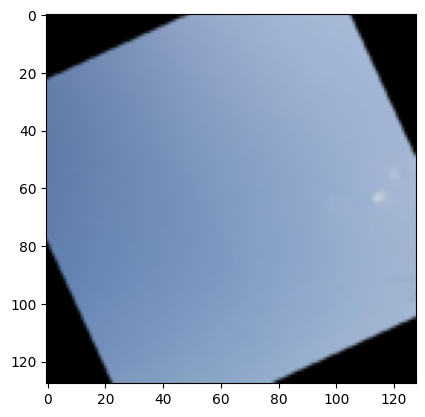

In [16]:
image, label = next(iter(dataloader_train))
# Reshape the image tensor
image = image.squeeze().permute(1, 2, 0)
# Display the image
plt.imshow(image)
plt.show()

In [27]:
from torch import nn


class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Define feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
        )
        self.classifier = nn.Linear(64 * 64 * 16, num_classes)

    def forward(self, x):
        # Pass input through feature extractor and classifier
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x    

In [28]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
])

# Create Dataset using ImageFolder
dataset_train = ImageFolder(
    'clouds/clouds_train',
    transform=train_transforms,
)

dataloader_train = DataLoader(
    dataset_train, shuffle=True, batch_size=16
)

In [30]:
# Define the model
net = Net(num_classes=7)
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in range(10):
    running_loss = 0.0
    # Iterate over training batches
    for data in dataloader_train:
        images, labels = data
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(dataloader_train)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1, Loss: 2.4188
Epoch 2, Loss: 1.6180
Epoch 3, Loss: 1.4500
Epoch 4, Loss: 1.3419
Epoch 5, Loss: 1.4820
Epoch 6, Loss: 1.2837
Epoch 7, Loss: 1.3003
Epoch 8, Loss: 1.2263
Epoch 9, Loss: 1.2611
Epoch 10, Loss: 1.1596


In [31]:
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
])

# Create Dataset using ImageFolder
dataset_test= ImageFolder(
    'clouds/clouds_test',
    transform=test_transforms,
)

dataloader_test = DataLoader(
    dataset_test, shuffle=True, batch_size=16
)

### Averaging multi-class metrics 
- With 7 classes, we have 7 precision and 7 recall scores
- We can analyze them per-class, or aggregate:
-- None: Metric is calculated per class and not aggregated
-- Micro average: global calculation
-- Macro average: mean of per-class metrics
-- Weighted average: weighted mean of per-class metrics

### When to use each:
- Micro: Imbalanced datasets
- Macro: Care about performance on small classes
- Weighted: Consider errors in larger classes as more important



In [34]:
from torchmetrics import Precision, Recall
import torch

# Define metrics
metric_precision = Precision(task='multiclass', num_classes=7, average='macro')
metric_recall = Recall(task='multiclass', num_classes=7, average='macro')

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
        metric_recall(preds, labels)

precision = metric_precision.compute()
recall = metric_recall.compute()
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.5487483739852905
Recall: 0.6100265979766846


In [40]:
# Define precision metric per class
metric_precision = Precision(
    task='multiclass', num_classes=7, average=None
)

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
precision = metric_precision.compute()

# Get precision per class
precision_per_class = {
    k: precision[v].item()
    for k, v
    in dataset_test.class_to_idx.items()
}

NameError: name 'pd' is not defined

In [38]:
precision

tensor([0.5455, 0.6703, 0.5556, 0.4968, 0.7568, 0.3878, 0.4286])

In [36]:
dataset_test.class_to_idx.items()

dict_items([('cirriform clouds', 0), ('clear sky', 1), ('cumulonimbus clouds', 2), ('cumulus clouds', 3), ('high cumuliform clouds', 4), ('stratiform clouds', 5), ('stratocumulus clouds', 6)])

In [45]:
pd.DataFrame(data=precision_per_class.values(), index=list(precision_per_class.keys()), columns=['Precision'])

,Precision
cirriform clouds,0.545455
clear sky,0.670330
cumulonimbus clouds,0.555556
cumulus clouds,0.496815
high cumuliform clouds,0.756757
stratiform clouds,0.387755
stratocumulus clouds,0.428571
